In [2]:
%load_ext autoreload
%autoreload 2
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch_kfac import KFAC
import tqdm.auto as tqdm

## Load MNIST dataset

In [5]:
batch_size = 1024

In [6]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
dataset1 = datasets.MNIST('../data', train=True, download=True,
                   transform=transform)
dataset2 = datasets.MNIST('../data', train=False,
                   transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

In [7]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.convolutions = nn.Sequential(
            nn.Conv2d(1, 2, (7, 7)),
            nn.Tanh(),
            nn.Conv2d(2, 4, (7, 7)),
            nn.Tanh(),
            nn.Conv2d(4, 4, (7, 7)),
            nn.Tanh(),
            nn.Conv2d(4, 8, (7, 7)),
            nn.Tanh(),
        )
        
        self.head = nn.Linear(128, 10)
    
    def forward(self, x):
        out = self.convolutions(x).reshape(x.shape[0], -1)
        return self.head(out)

# KFAC with model distribution

In [16]:
model = Classifier().cuda()
optim = KFAC(model, 9e-3, 1e-3, momentum_type='regular', momentum=0.95, adapt_damping=True, update_cov_manually=True)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [17]:
kfac_losses = []
with tqdm.tqdm(train_loader) as progress:
    for inp, labels in progress:
        inp, labels = inp.cuda(), labels.cuda()
        model.zero_grad()
        # Estimate with model distribution
        with optim.track_forward():
            out = model(inp)
            out_samples = torch.multinomial(torch.softmax(out.detach(), 1), 1).reshape(out.shape[0])
            loss = loss_fn(out, out_samples)
        with optim.track_backward():
            loss.backward()
        optim.update_cov()
        # Compute loss to backprop
        model.zero_grad()
        with optim.track_forward():
            out = model(inp)
            loss = loss_fn(out, labels)
        with optim.track_backward():
            loss.backward()
        optim.step(loss=loss)
        progress.set_postfix({
            'loss': loss.item(),
            'damping': optim.damping.item()
        })
        kfac_losses.append(loss.item())

100%|██████████| 235/235 [00:38<00:00,  6.10it/s, loss=0.252, damping=0.00408]


# KFAC with data distribution

In [10]:
model = Classifier().cuda()
optim = KFAC(model, 9e-3, 1e-3, momentum_type='regular', momentum=0.95, adapt_damping=True, update_cov_manually=False)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [11]:
kfac_data_losses = []
with tqdm.tqdm(train_loader) as progress:
    for inp, labels in progress:
        inp, labels = inp.cuda(), labels.cuda()
        model.zero_grad()
        with optim.track_forward():
            out = model(inp)
            loss = loss_fn(out, labels)
        with optim.track_backward():
            loss.backward()
        optim.step(loss=loss)
        progress.set_postfix({
            'loss': loss.item(),
            'damping': optim.damping.item()
        })
        kfac_data_losses.append(loss.item())

100%|██████████| 235/235 [00:36<00:00,  6.36it/s, loss=0.299, damping=0.00525]


# Adam

In [12]:
model = Classifier().cuda()
optim = torch.optim.Adam(model.parameters())
loss_fn = nn.CrossEntropyLoss(reduction='mean')

In [13]:
adam_losses = []
with tqdm.tqdm(train_loader) as progress:
    for inp, labels in progress:
        inp, labels = inp.cuda(), labels.cuda()
        model.zero_grad()
        out = model(inp)
        loss = loss_fn(out, labels)
        loss.backward()
        optim.step()
        progress.set_postfix({
            'loss': loss.item()
        })
        adam_losses.append(loss.item())

100%|██████████| 235/235 [00:10<00:00, 22.46it/s, loss=0.287]


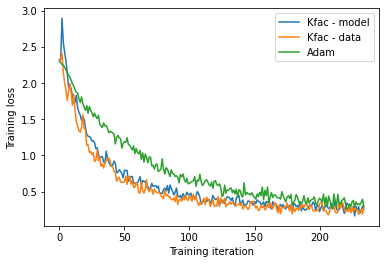

In [18]:
import matplotlib.pyplot as plt
plt.plot(kfac_losses)
plt.plot(kfac_data_losses)
plt.plot(adam_losses)
plt.xlabel('Training iteration')
plt.ylabel('Training loss')
plt.legend(['Kfac - model', 'Kfac - data', 'Adam'])